# TikTok - Machine Learning Model

This work involves building a tree-based model to predict a binary target variable. The model's objective is to help reduce misinformation within TikTok videos by predicting whether a video presents a *claim* or an *opinion*.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [ ]:
# reading the data
df = pd.read_csv("tiktok_dataset.csv").dropna(axis=0)
df.head(10)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0
5,6,claim,8972200955,35,someone shared with me that gross domestic pro...,not verified,under review,336647.0,175546.0,62303.0,4293.0,1857.0
6,7,claim,4958886992,16,someone shared with me that elvis presley has ...,not verified,active,750345.0,486192.0,193911.0,8616.0,5446.0
7,8,claim,2270982263,41,someone shared with me that the best selling s...,not verified,active,547532.0,1072.0,50.0,22.0,11.0
8,9,claim,5235769692,50,someone shared with me that about half of the ...,not verified,active,24819.0,10160.0,1050.0,53.0,27.0
9,10,claim,4660861094,45,someone shared with me that it would take a 50...,verified,active,931587.0,171051.0,67739.0,4104.0,2540.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19084 entries, 0 to 19083
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19084 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19084 non-null  int64  
 3   video_duration_sec        19084 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19084 non-null  object 
 6   author_ban_status         19084 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.9+ MB


In [ ]:
df.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19084.000000,1.908400e+04,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9542.500000,5.624840e+09,32.423811,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5509.220604,2.537030e+09,16.226470,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4771.750000,3.425100e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9542.500000,5.609500e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14313.250000,7.840823e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19084.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


TikTok users have the ability to report videos they think infringe upon the platform's terms of service. With millions of videos uploaded and viewed each day, it is unfeasible for every reported video to be reviewed by a human moderator. Analysis has shown that videos from users who breach terms of service are more likely to contain claims than opinions. Therefore, distinguishing between claim and opinion videos can be valuable. TikTok aims to build a machine learning model to distinguish claims from opinions. Opinion-labeled videos would be less likely to undergo human review, whereas videos classified as claims would undergo further scrutiny to determine if they should be prioritized for review. For instance, videos classified as claims could be ranked by their number of reports, and the top-ranked videos might be reviewed by a human moderator each day. This model would significantly assist in prioritizing videos that are likely to breach TikTok's terms of service for human moderators.

In [ ]:
# checking for duplicate values
print("Number of duplicates:", df.duplicated().sum())

# checking class balance
df["claim_status"].value_counts(normalize=True)

Number of duplicates: 0


,proportion
claim_status,
claim,0.503458
opinion,0.496542


In [ ]:
# creating new column for transcript length
df["text_length"] = df["video_transcription_text"].str.len()

# calculating the average transcript length by claim status
df[["claim_status", "text_length"]].groupby("claim_status").mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


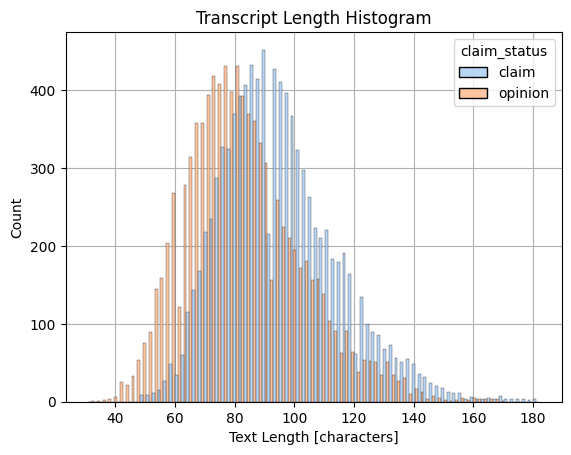

In [ ]:
# creating a histogram for the distribution of transcript length
sns.histplot(data=df,
             stat="count",
             multiple="dodge",
             x="text_length",
             kde=False,
             palette="pastel",
             hue="claim_status",
             element="bars",
             legend=True,
             zorder=3)
plt.title("Transcript Length Histogram")
plt.xlabel("Text Length [characters]")
plt.ylabel("Count")
plt.grid(zorder=0)
plt.show()

The target variable is `claim_status`, a binary indicator that distinguishes between claim and opinion videos. For each video, the model aims to predict whether it is a claim or an opinion. This task is a binary classification problem. To select the best evaluation metric, it is necessary to consider potential errors. A false positive occurs when the model labels a video as a claim when it is actually an opinion. A false negative occurs when the model labels a video as an opinion when it is actually a claim. In this scenario, it is preferable to have false positives rather than false negatives. Identifying all potential terms of service violations is crucial, even if it means some opinions are wrongly classified as claims. Misclassifying an opinion as a claim means it might undergo human review, whereas a misclassified claim could go unchecked. Therefore, recall is chosen as the primary evaluation metric to minimize false negatives.

In [ ]:
# dropping unnecessary features
X = df.copy()
X = X.drop(["#", "video_id"], axis=1)

# encoding the target variable
X["claim_status"] = X["claim_status"].replace({"opinion": 0, "claim": 1})

# encoding the remaining categorical values
X = pd.get_dummies(X, columns=["verified_status", "author_ban_status"], drop_first=True)

In [ ]:
# isolating the features (X) and the target variable (y)
y = X["claim_status"]
X = X.drop(["claim_status"], axis=1)

# splitting data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

Knowledge of basic NLP concepts could be advantageous due to the nature of the provided text data. The feature `video_transcription_text` is text-based and can be converted into numerical data using methods like *CountVectorizer*, which breaks text into groups of consecutive words (n-grams). For example, the phrase "a dime for a cup of coffee" split into 2-grams becomes "a dime", "dime for", "for a", "a cup", "cup of" and "of coffee". This process is repeated for each observation, treating each n-gram as a distinct feature.

In [ ]:
# count vectorizer
cnt_vec = CountVectorizer(ngram_range=(2, 3), max_features=15, stop_words="english")

# name of column for the transcript
trsc_col = "video_transcription_text"

In [ ]:
# extracting numerical features from the video transcript for the training data
cnt_trsc_features = cnt_vec.fit_transform(X_train[trsc_col]).toarray()
cnt_df = pd.DataFrame(data=cnt_trsc_features, columns=cnt_vec.get_feature_names_out())
X_train_final = pd.concat([X_train.drop(columns=[trsc_col]
                                        ).reset_index(drop=True), cnt_df], axis=1)

In [ ]:
# extracting numerical features from the video transcript for the validation data
validation_cnt_trsc_features = cnt_vec.transform(X_val[trsc_col]).toarray()
validation_cnt_df = pd.DataFrame(data=validation_cnt_trsc_features, columns=cnt_vec.get_feature_names_out())
X_val_final = pd.concat([X_val.drop(columns=[trsc_col]
                                    ).reset_index(drop=True), validation_cnt_df], axis=1)

In [ ]:
# extracting numerical features from the video transcript for the testing data
test_cnt_trsc_features = cnt_vec.transform(X_test[trsc_col]).toarray()
test_cnt_df = pd.DataFrame(data=test_cnt_trsc_features, columns=cnt_vec.get_feature_names_out())
X_test_final = pd.concat([X_test.drop(columns=[trsc_col]
                                      ).reset_index(drop=True), test_cnt_df], axis=1)

In [ ]:
# random forest classifier
rf = RandomForestClassifier(random_state=42)

# hyperparameters for tuning
cv_params = {"max_depth": [5, 7, None],
             "max_features": [0.3, 0.6, 0.9, 1.0],
             "max_samples": [0.5, 0.7, 0.9, 1.0],
             "min_samples_leaf": [1, 2, 4, 6],
             "min_samples_split": [2, 4, 6],
             "n_estimators": [75, 100, 200]}

# scoring metrics
scoring_criteria = ["accuracy", "precision", "recall", "f1"]

# GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring_criteria, cv=5, refit="recall")

In [ ]:
rf_cv.fit(X_train_final, y_train)

In [ ]:
# examining best score
rf_cv.best_score_

0.9951682484900776

In [ ]:
# examining best architecture
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
# XGBoost classifier
xgb_clf = XGBClassifier(objective="binary:logistic", random_state=0)

# hyperparameters for tuning
cv_params = {"learning_rate": [0.1, 0.01, 0.001],
             "max_depth": [6, 8, 10, 12],
             "min_child_weight": [1, 3, 5],
             "n_estimators": [300, 400, 500]}

# scoring metrics
scoring_criteria = ["accuracy", "precision", "recall", "f1"]

# GridSearchCV object
xgb_cv = GridSearchCV(xgb_clf, cv_params, scoring=scoring_criteria, cv=5, refit="recall")

In [ ]:
xgb_cv.fit(X_train_final, y_train)

In [ ]:
# examining best score
xgb_cv.best_score_

0.989645054622456

In [ ]:
# examining best architecture
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 300}

In [ ]:
def get_test_results(model_name:str, preds, y_test_data):
    """
    This function generates a table of test scores (precision, recall, f1, accuracy).
    """
    # calculating performance scores
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    # creating table of results
    table = pd.DataFrame({"model": [model_name],
                          "precision": [precision],
                          "recall": [recall],
                          "F1": [f1],
                          "accuracy": [accuracy]})
    return table


def plot_confusion_matrix(y_target, y_pred, clf_cv, title):
    """
    This function plots the confusion matrix based on given actual and predicted values.
    """
    # generating array of values for confusion matrix
    log_cm = confusion_matrix(y_target, y_pred, labels=clf_cv.classes_)

    # plotting confusion matrix
    log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=clf_cv.classes_)
    log_disp.plot()
    plt.title(title)
    plt.show()

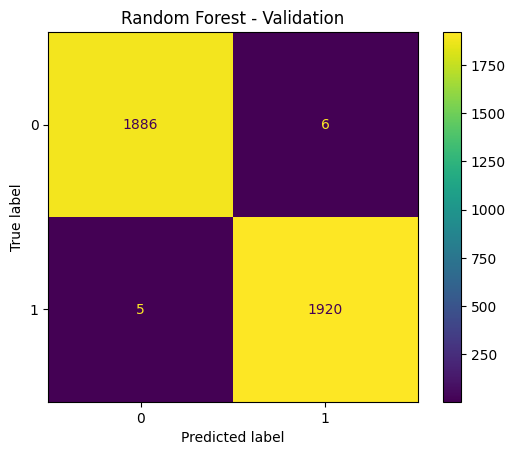

In [ ]:
# getting predictions on the validation set for the best random forest model
y_pred = rf_cv.best_estimator_.predict(X_val_final)

# plotting confusion matrix for the best random forest model
plot_confusion_matrix(y_val, y_pred, rf_cv, "Random Forest - Validation")

In [ ]:
# creating classification report for random forest model
target_labels = ["opinion", "claim"]
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



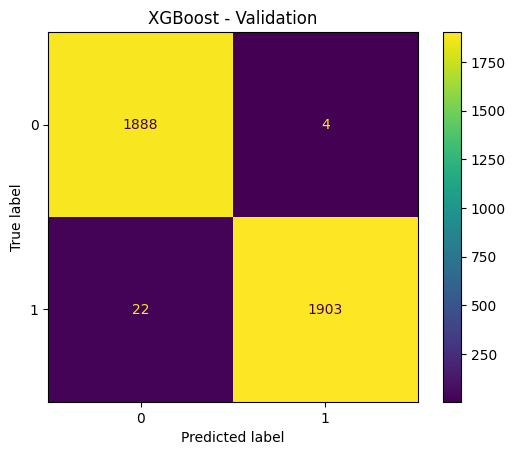

In [ ]:
# getting predictions on the validation set for the best XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

# plotting confusion matrix for the best XGBoost model
plot_confusion_matrix(y_val, y_pred, xgb_cv, "XGBoost - Validation")

In [ ]:
# creating classification report for XGBoost model
target_labels = ["opinion", "claim"]
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



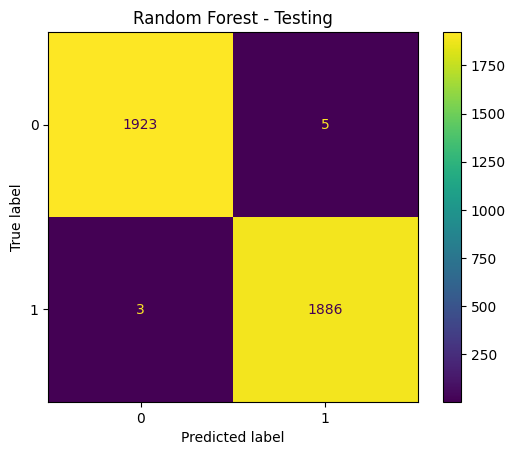

In [ ]:
# getting predictions on the testing set for the best model
y_pred = rf_cv.best_estimator_.predict(X_test_final)

# plotting confusion matrix for the best model
plot_confusion_matrix(y_test, y_pred, rf_cv, "Random Forest - Testing")

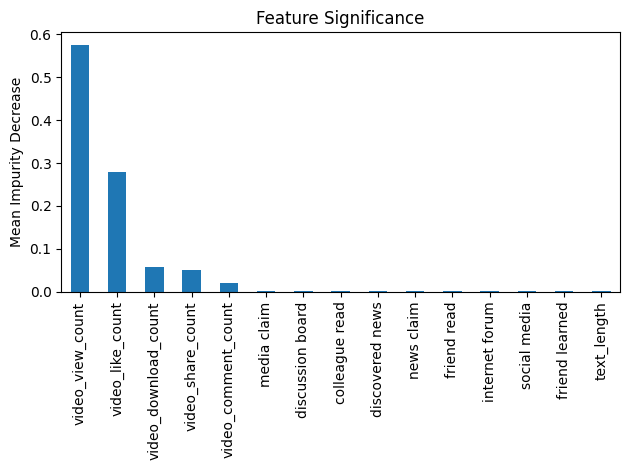

In [ ]:
# visualizing the feature significance
feature_significance = rf_cv.best_estimator_.feature_importances_
rf_feature_significance = pd.Series(feature_significance, index=X_test_final.columns)
rf_feature_significance = rf_feature_significance.sort_values(ascending=False)[:15]

fig, ax = plt.subplots()
rf_feature_significance.plot.bar(ax=ax)
ax.set_title("Feature Significance")
ax.set_ylabel("Mean Impurity Decrease")
fig.tight_layout()

In [ ]:
# getting scores on testing data for the best model
get_test_results("Random Forest", y_pred, y_test)

,model,precision,recall,F1,accuracy
0,Random Forest,0.997356,0.998412,0.997884,0.997904


The Random Forest model produced less misclassifications than the XGBoost model during validation, while the latter model had a tendency to misclassify claims. As identifying claims is the priority, the Random Forest model's higher recall makes it the preferred choice. The key predictive features were all related to user engagement metrics, aligning with prior exploratory data analysis. The final model is recommended due to its excellent performance on validation and test sets, alongside consistently high precision and F1 scores. It effectively classifies claim and opinion videos and bases its predictions primarily on engagement metrics, such as views, likes, shares and downloads. As the current model's performance is already near perfect, new features are not necessary. However, additional features like the number of times a video was reported or the total reports for an author's videos could enhance performance.